In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as ss
import pandas as pd
from scipy.stats import binom
import plotly.graph_objects as go
import scipy.optimize as so


## Constant-Weight Code Vs Optimal-Code
1) Generate a uniform and a power law dataset
2) Define optimal N and A
3) Compute the cost
4) Compare

In [2]:
## General Settings
W=130

#### Test if sum of freq=1 :  True


Text(0, 0.5, 'Frequency')

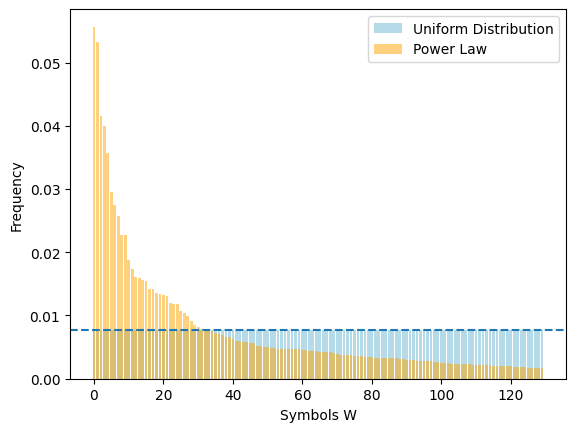

In [10]:
## Power Law using https://data.world/tronovan/shakespeare-word-frequencies/workspace/file?filename=shakes_charts.ipynb

DFshak = pd.read_csv('shakespeare.csv')
DFshak = DFshak.rename(columns={DFshak.columns[0]:'count',DFshak.columns[1]:'word'})
## Only assume the first W words and normalize accoriding to it
Total_wshak=DFshak['count'][:W].sum()
DFshak['frequency']=DFshak['count']/Total_wshak
DFshak.head()
power_d=np.array(DFshak['frequency'][:W])
print("#### Test if sum of freq=1 : ",power_d.sum()==1)

## Uniform Distribution
uniform_d=np.zeros(W)+1/W

x=range(0,W)

## Fit Zipfs distribution
def zipf(x,alpha):
    return 1/(ss.zeta(alpha)*x**(alpha))

zeta_fit=so.curve_fit(zipf,x,power_d)


## Plot Two distributions
plt_range=W
plt.bar(x[:plt_range],uniform_d[:plt_range],alpha=0.9,label='Uniform Distribution',color='lightblue')
plt.bar(x[:plt_range],power_d[:plt_range],alpha=0.5,label='Power Law',color='orange')
plt.legend()
plt.xlabel('Symbols W')
plt.ylabel('Frequency')

In [34]:
## Solve Constant Weight Code
def entropyR(r):
    return -(r*np.log(r))-((1-r)*np.log(1-r))
def findOptimalCWC(W,r,research): # r=N/A
    Hr=entropyR(r)
    Cost=(1+r)*(np.log(W)/Hr)
    idx_r_optim=np.argmin(Cost)
    r_optim=r[idx_r_optim]
    N_optim=np.log(W)/entropyR(r_optim)
    N_fin=int(np.ceil(N_optim)+1)
    a_fin=int(np.ceil(N_fin*r_optim))
    if research:
        if ss.binom(N_fin,a_fin)<W:
            final=0
            print('---Problem----Search Solution around it')
            print('---False Found N,A:',N_fin,a_fin,'/ Binomial :', ss.binom(N_fin,a_fin), ' < W:',W)
            for a2 in range(a_fin,N_fin+1):
                if ss.binom(N_fin,a2)>=W and final==0:
                    print('---Problem Solved via different A')
                    final=1
                    a_fin=a2
            if final==0:
                for N2 in range(N_fin+1,N_fin+3):
                    for a2 in range(0,N2):
                        if ss.binom(N2,a2)>=W and final==0:
                            print('---Problem Solved via different N & A')
                            final=1
                            a_fin=a2
                            N_fin=N2
    Cost_fin=a_fin+N_fin
    return a_fin,N_fin,Cost_fin,Cost

In [35]:
ratio_NA=np.linspace(0.01,0.99,5000)
A_cwc,N_cwc,Cost_cwc,Costall_cwc=findOptimalCWC(W,ratio_NA,True)
#plt.plot(ratio_NA,Cost_cwc)
#plt.title('Cost Optim for Pau Uniform Distrib')
#plt.vlines(x=[A_cwc/N_cwc],color='g',ymin=10,ymax=35)
print("Optimal Constant Weight Code Parameters:")
print('W ',W, '/ N ',N_cwc,'/ A ',A_cwc,'/ Binomial coeff:',ss.binom(N_cwc,A_cwc) )
print('Total Cost: ',W*Cost_cwc)


---Problem----Search Solution around it
---False Found N,A: 9 4 / Binomial : 126.0  < W: 130
---Problem Solved via different N & A
Optimal Constant Weight Code Parameters:
W  130 / N  10 / A  4 / Binomial coeff: 210.0
Total Cost:  1820


In [36]:
## Optimal Code
def findN(W):
    N=np.ceil(np.log2(W))
    return N
#def GenerateBinomial(N):
#    p=1/2
#    x_cBd=np.linspace(0, 2**N+1, 100*2**N)
#    y_cBd=binom.cdf(x_cBd, N,p)
#    y_pBd=binom.pmf(x_cBd, N,p)
#    return x_cBd,y_cBd,y_pBd
#def findA(W,x_cNd,y_cNd,N_o):
#    idx_A=np.argmin(np.abs(W-(2**N_o)*y_cNd))
#    A=np.ceil(x_cNd[idx_A])
#    return A
#def OptimalCode2(W):
#    N_oc=int(findN(W))
#    x_CB,y_CB,y_PB=GenerateBinomial(N_oc)
#    A_oc=int(findA(W,x_CB,y_CB,N_oc))
#    # Compute Cost A
#    alpha_A=[]
#    Binomal_Total=0
#    for aj in range(0,A_oc+1): # +1 because want to reach Afinal
#        bino=int(ss.binom(N_oc, aj))
#        Binomal_Total+=bino
#        Value=int(aj)
#        intemr=np.zeros(bino)+Value
#        alpha_A=np.concatenate((alpha_A,intemr))
#    #Clean alpha such that keep only W components
#    alpha_AW=alpha_A[:W]
#    C_A=np.sum(alpha_AW)
#    # Compute Cost N
#    C_N=N_oc*W
#    C_total=C_A+C_N
#    return N_oc,A_oc,alpha_AW,Binomal_Total,C_total
#
def BinomialCDF(N):
    Bin_cdf=[]
    for aj in range(0,N+1):
        bin_interm=[int(ss.binom(N,k)) for k in range(0,aj+1)]
        Bin_cdf.append(np.sum(bin_interm)/2**N) # divide by 2**N to reach 1 at end of cdf
    Pascal=bin_interm
    return Bin_cdf,Pascal
def OptimalCode(W,r=1,N=0):
    if N==0:
        print('---no N as input')
        N=int(findN(W))
    Bin_cdf,Pascal=BinomialCDF(N)
    Optimal_cdf=np.array([Bin_cdf_i-W/2**N for Bin_cdf_i in Bin_cdf])
    Optimal_cdf[Optimal_cdf<0]=np.nan # delete all Case where we would have not enough Symbols (A too small) (can't use abs else if W=160 and N,A gives 157, it will be closest but not enough symbols)
    A=np.nanargmin(Optimal_cdf)
    CW_used=[Pascal_i for Pascal_i in Pascal[:int(A)]] # Keep all binomial
    CW_used.append(W-np.sum(CW_used)) # Fullfil the last layer with just enough codewords
    Alpha=[]
    for aj in range(0,A+1): # +1 because want to reach Afinal
        Value=int(aj)
        intemr=np.zeros(CW_used[aj])+Value
        Alpha=np.concatenate((Alpha,intemr))
    Cost_Alpha=[CW_used[i]*i for i in range(0,A+1)]
    Cost_N=N*W
    Cost_Total=(r*np.sum(Alpha)+Cost_N)
    return N,A,Alpha,CW_used,Cost_Total

In [37]:
N_oc,A_oc,alpha_Aoc,bin_oc,Cost_oc=OptimalCode(W)
print("Optimal Code Parameters:")
print('W ',W, '/ N ',N_oc,'/ A ',A_oc,'/ Binomial coeff:',bin_oc,'/ Sum Binom:',np.sum(bin_oc) )
print('Total Cost: ',Cost_oc)


---no N as input
Optimal Code Parameters:
W  130 / N  8 / A  4 / Binomial coeff: [1, 8, 28, 56, 37] / Sum Binom: 130
Total Cost:  1420.0


In [38]:
## Cost for CWC
Cost_cwc_power=power_d*(N_cwc+A_cwc)*W
Cost_cwc_uniform=uniform_d*(N_cwc+A_cwc)*W
## Cost for OC
Cost_oc_power=[]
Cost_oc_uni=[]

for i in range(0,W):
    ci=power_d[i]*(alpha_Aoc[i]+N_oc)*W
    ci_uni=uniform_d[i]*(alpha_Aoc[i]+N_oc)*W
    Cost_oc_power.append(ci)
    Cost_oc_uni.append(ci_uni)


Text(0, 0.5, 'Cost')

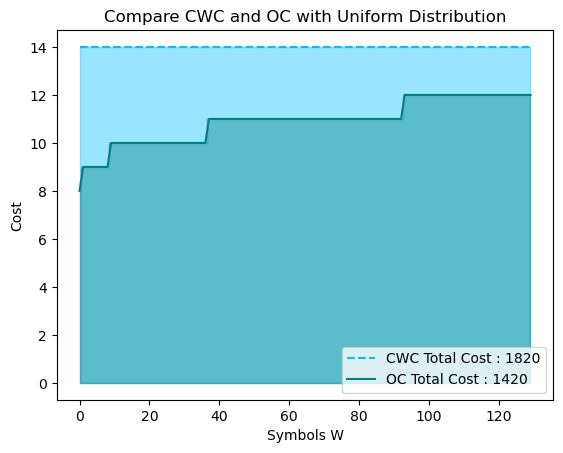

In [39]:
## Plot Uniform
label_cwc="CWC Total Cost : "+str(int(np.sum(Cost_cwc_uniform)))
plt.plot(x,Cost_cwc_uniform,label=label_cwc,color='deepskyblue',linestyle='dashed')
plt.fill_between(x, Cost_cwc_uniform, step="mid", alpha=0.4,color='deepskyblue')

label_oc="OC Total Cost : "+str(int(np.sum(Cost_oc_uni)))
plt.plot(x,Cost_oc_uni,label=label_oc,color='teal')
plt.fill_between(x, Cost_oc_uni, step="mid", alpha=0.4,color='teal')

#plt.plot(x,Cost_cwc_uniform,label=['OC--Total:',np.sum(Cost_oc_uni)])
plt.legend(loc='lower right')
plt.title('Compare CWC and OC with Uniform Distribution')
plt.xlabel('Symbols W')
plt.ylabel('Cost')

Text(0, 0.5, 'Cost')

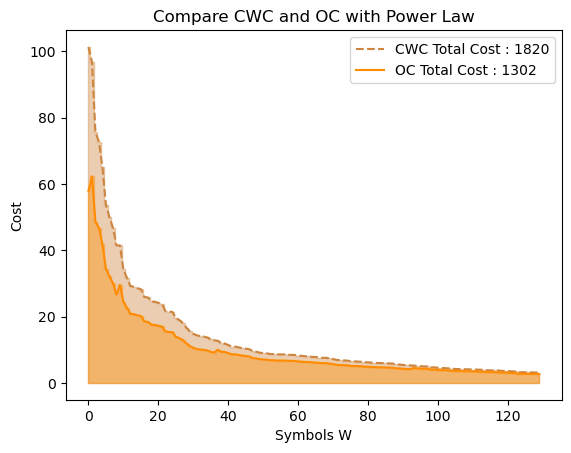

In [40]:
## Plot PowerLaw
label_cwc="CWC Total Cost : "+str(int(np.sum(Cost_cwc_power)))
plt.plot(x,Cost_cwc_power,label=label_cwc,color='peru',linestyle='dashed')
plt.fill_between(x, Cost_cwc_power, step="mid", alpha=0.4,color='peru')

label_oc="OC Total Cost : "+str(int(np.sum(Cost_oc_power)))
plt.plot(x,Cost_oc_power,label=label_oc,color='darkorange')
plt.fill_between(x, Cost_oc_power, step="mid", alpha=0.4,color='darkorange')

#plt.plot(x,Cost_cwc_uniform,label=['OC--Total:',np.sum(Cost_oc_uni)])
plt.legend(loc='upper right')
plt.title('Compare CWC and OC with Power Law')
plt.xlabel('Symbols W')
plt.ylabel('Cost')

## Compute With R

In [41]:
R=[1,4,8,12,20,30]
diff_N=20
N_min=N_oc
N_max=N_min+diff_N


In [42]:
## Compute solution for each r
R_Cost_all=[]
R_N_all=range(N_min,N_max)
R_A_all=[]

for ri in R:
    R_c=[]
    R_a=[]
    for ni in R_N_all:
        Ni,Ai,alpha_i,bin_i,Cost_i=OptimalCode(W,ri,ni)
        R_c.append(Cost_i)
        R_a.append(Ai)
    R_Cost_all.append(R_c)
    R_A_all.append(R_a)

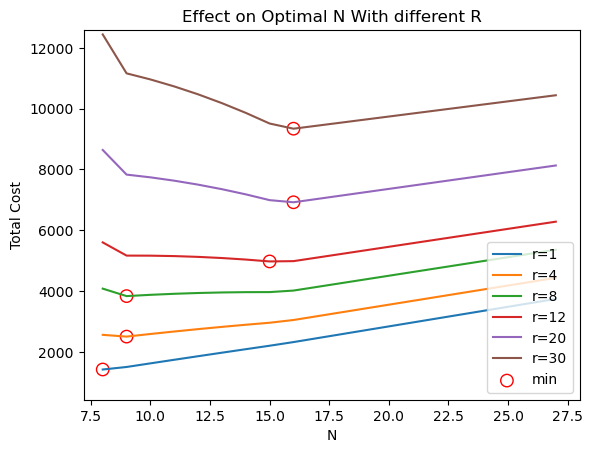

In [43]:
for i,ri in enumerate(R):
    lab='r='+str(ri)
    plt.plot(R_N_all,R_Cost_all[i],label=lab)
    ymin=np.min(R_Cost_all[i])
    xmin=N_min+np.argmin(R_Cost_all[i])
    plt.scatter(xmin,ymin,s=80, facecolors='none', edgecolors='r')
# for legend
plt.scatter(-100,-100,s=80, facecolors='none', edgecolors='r',label='min') # dummy pts
# settings
plt.xlim([N_min-0.1*N_min,N_max])
plt.ylim([np.min(R_Cost_all)-0.7*np.min(R_Cost_all),np.max(R_Cost_all)+0.1*np.min(R_Cost_all)])
plt.xlabel('N')
plt.ylabel('Total Cost')
plt.title('Effect on Optimal N With different R')
plt.legend(loc='lower right')

In [83]:
## Surface
R_end=30
R_vec=np.linspace(0.5,R_end,diff_N)
vec_R_N_all=range(N_min,N_max)
## Compute solution for each r
vec_R_Cost_all=[]

for ri in R_vec:
    vec_R_c=[]
    for ni in vec_R_N_all:
        Ni,Ai,alpha_i,bin_i,Cost_i=OptimalCode(W,ri,ni)
        vec_R_c.append(Cost_i)
    vec_R_Cost_all.append(vec_R_c)


#data=go.Surface(x=)
#fig=go.Figure(data=[])

In [84]:

idx_min=np.argmin(np.array(vec_R_Cost_all),axis=1) # Compute all minimum
Bis=np.zeros((np.array(vec_R_Cost_all)).shape)
for i,j in enumerate(idx_min):
    Bis[i][j]=1
surface_color=Bis
colorscale_ = [ 'blue','red']
contours_={"x": {"show": True, "start":N_min, "end": N_max, "size": 1, "color": "grey"},
            "y": {"show": True, "start": 0, "end": R_end, "size": 1, "color": "grey"}}
data=[go.Surface(z=np.array(vec_R_Cost_all), x=np.array(vec_R_N_all), y=np.array(R_vec),
                                surfacecolor=surface_color,
                                contours=contours_,
                                colorscale=colorscale_)]



In [85]:
fig = go.Figure(data)
fig.update_layout(
    title='Surface of Cost with Variation of R and N',
    autosize=False,
    width=800,
    height=800,
    scene=dict(
        xaxis_title='N Axis',
        yaxis_title='R Axis',
        zaxis_title='Cost Axis'
    )
)

fig.show()

In [91]:
#fig=plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(np.array(vec_R_N_all), np.array(R_vec), np.array(vec_R_Cost_all), facecolors=surface_color, edgecolor='none')
#ax.view_init(elev=50, azim=-45)
#plt.show()             

In [92]:
idx_min=np.argmin(np.array(vec_R_Cost_all),axis=1) # Compute all minimum
Bis=np.full((np.array(vec_R_Cost_all)).shape,'blue')
for i,j in enumerate(idx_min):
    Bis[i][j]='red'
surface_color=Bis

In [93]:
ax.view_init(elev=10, azim=100)
plt.show()